**BIBLIOTECAS**


Bibliotecas utilizadas para el desarrollo de la práctica.

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import sklearn.compose
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

**FICHEROS TRAIN Y TEST**

Apertura de los ficheros train y test desde el repositorio de GitHub, asignación de nuevas columnas a los DataFrame y por último reorganización de las nuevas columnas para posteriormente realizar un preprocesamiento mucho más cómodo.

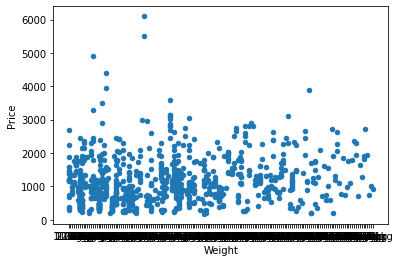

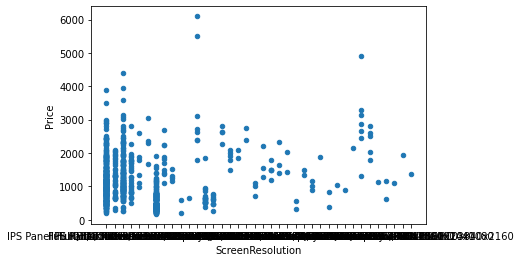

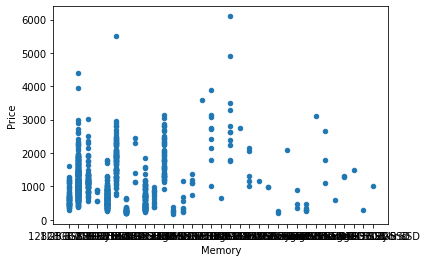

In [ ]:
fichero_test = pd.read_csv("https://raw.githubusercontent.com/jorgegranadossobrino/Ficheros/main/test.csv", sep=",")
fichero_train = pd.read_csv("https://raw.githubusercontent.com/jorgegranadossobrino/Ficheros/main/train.csv", sep=",")


fichero_train = fichero_train.assign(SSD = False, GHz = 0.0, Gama = "", Touchscreen = False, Ips = False, Gtx = False, Linux = False, MacOS = False)
fichero_test = fichero_test.assign(SSD = False,  GHz = 0.0, Gama = "", Touchscreen = False, Ips = False, Gtx = False, Linux = False, MacOS = False)


# Reorganizar columnas
fichero_train = fichero_train[['LaptopId', 'Company', 'Product', 'TypeName', 'Inches' , 'ScreenResolution' , 'Cpu' , 'Ram' , 'Memory', 'Gpu' , 'OpSys', 'Weight', 'SSD', 'GHz', 'Gama', 'Touchscreen', 'Ips', 'Gtx', 'Price' ]]

fichero_train.plot.scatter('Weight','Price')
fichero_train.plot.scatter('ScreenResolution','Price')
fichero_train.plot.scatter('Memory','Price')

**FUNCIÓN DE PREPROCESADO**

Código de la función para transformar los datos (sobre todo los datos discretos) del DataFrame para posteriormente utilizarlos en el preprocesado, tanto en los ficheros de train como el de test. Además de la creación de un array para guardar los precios de los productos para su posterior comparación.

In [ ]:
def preprocesado_datos(fichero):
  X = np.array(fichero)
  for i in range  (len(X)):

    '''------------------------- CPU GHZ -------------------------'''
    p1 = re.compile('\d\.\d+GHz')
    texto = X[i][6]  # texto a comprobar (columna de la iteracion)
    auxGhz = p1.search(texto)  # devuelve un objeto de coincidencia
    gamaIntel = 14
    if "Intel" in X[i][6]:
        #Clasificaremos en 4 gamas: Entrada, Baja, Media y Alta
        if "i7" in X[i][6] or "Xeon" in X[i][6] or "i9" in X[i][6]:
            X[i][gamaIntel] = "Alta"
        elif "i5" in X[i][6] :
            X[i][gamaIntel] = "Media"
        elif "i3" in X[i][6] :
            X[i][gamaIntel] = "Baja"
        else:
            X[i][gamaIntel] = "Entrada"
    elif "AMD" in X[i][6] :
        if "A10" in X[i][6] :
          if auxGhz == None: # para numeros enteros
              p1 = re.compile('\dGHz')
              auxGhz = p1.search(texto)
              auxGhz2 = auxGhz.group()
              p2 = re.compile('\d')  # quitar 'GHz'
              y = p2.search(auxGhz2)
              X[i][13] = float(y.group())   # numero sin GHz
          else:
              auxGhz2 = auxGhz.group()
              p2 = re.compile('\d.\d+')  # quitar 'GHz'
              y = p2.search(auxGhz2)
              X[i][13] = float(y.group()) # numero sin GHz

    '''---------------------- DISK / MEMORY ----------------------'''
    if "SSD" in X[i][8] or "Hybrid" in X[i][8]:
      X[i][12] = True

    '''--------------------------- RAM ---------------------------'''
    X[i][7] = X[i][7].replace("GB", "")

    '''-------------------------- PESO --------------------------'''
    X[i][11] = X[i][11].replace("kg", "")

    '''----------------------- RESOLUCION -----------------------'''
    if "Touchscreen" in X[i][5] or "touchscreen" in X[i][5]:
      X[i][15] = True
    if "IPS" in X[i][5]:
      X[i][16] = True
    resolution = X[i][5].split(" ")
    X[i][5] = resolution[-1]

    '''--------------------------- GPU ---------------------------'''
    if "GTX" in X[i][9] or "Gtx" in X[i][9] or "gtx" in X[i][9]:
      X[i][17] = True
    if X[i][9].find("Nvidia") != -1:
      X[i][9] = "Nvidia"
    elif X[i][9].find("Intel") != -1:
      X[i][9] = "Intel"
    elif X[i][9].find("AMD") != -1:
      X[i][9] = "AMD"
    else:
      X[i][9] = "OTRO"
  return X


X_train = preprocesado_datos(fichero_train)
X_test_original = preprocesado_datos(fichero_test)
y_precio = []
for i in range (len(X_train)):
  y_precio.append(X_train[i][18])

**PREPROCESAMIENTO DE DATOS**

Preprocesamiento de datos de los ficheros train y test utilizando las transformaciones correspondientes para alcanzar el mejor entrenamiento del modelo, además de desechar los datos que no aporten mejoras al modelo.

In [ ]:
train_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("LaptopId", "drop", [0]),
    #("Company", sklearn.preprocessing.OrdinalEncoder(), [1]),
    ("Company", "drop", [1]),
    #("Product", sklearn.preprocessing.OrdinalEncoder(), [2]),
    ("Product", "drop", [2]),
    ("TypeName", sklearn.preprocessing.OrdinalEncoder(), [3]),
    ("Inches", sklearn.preprocessing.StandardScaler(), [4]),
    #("Inches", "drop", [4]),
    ("ScreenResolution", sklearn.preprocessing.OrdinalEncoder(), [5]),
    ("Cpu", sklearn.preprocessing.OrdinalEncoder(), [6]),
    #("Cpu", "drop", [6]),
    ("Ram", sklearn.preprocessing.StandardScaler(), [7]),
    ("Memory", sklearn.preprocessing.OrdinalEncoder(), [8]),
    #("Memory", "drop", [8]),
    #("Gpu", sklearn.preprocessing.OrdinalEncoder(), [9]),
    ("Gpu", "drop", [9]),
    ("OpSys", sklearn.preprocessing.OrdinalEncoder(), [10]),
    #("OpSys", "drop", [10]),
    ("Weight", sklearn.preprocessing.StandardScaler(), [11]),
    ("SSD", "passthrough",[12]),
    ("GHz", sklearn.preprocessing.MinMaxScaler(), [13]),
    #("GHz","drop", [13]),
    #("Gama", sklearn.preprocessing.OrdinalEncoder(categories=[['Entrada', 'Baja', 'Media', 'Alta']]), [14]),
    ("Gama", sklearn.preprocessing.OrdinalEncoder(), [14]),
    ("Touchscreen", "passthrough", [15]),
    ("Ips", "passthrough", [16]),
    ("Gtx", "passthrough", [17]),
    ("Precio", "drop", [18])

]);

test_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("LaptopId", "drop", [0]),
    #("Company", sklearn.preprocessing.OrdinalEncoder(), [1]),
    ("Company", "drop", [1]),
    #("Product", sklearn.preprocessing.OrdinalEncoder(), [2]),
    ("Product", "drop", [2]),
    ("TypeName", sklearn.preprocessing.OrdinalEncoder(), [3]),
    ("Inches", sklearn.preprocessing.StandardScaler(), [4]),
    #("Inches", "drop", [4]),
    ("ScreenResolution", sklearn.preprocessing.OrdinalEncoder(), [5]),
    ("Cpu", sklearn.preprocessing.OrdinalEncoder(), [6]),
    #("Cpu", "drop", [6]),
    ("Ram", sklearn.preprocessing.StandardScaler(), [7]),
    ("Memory", sklearn.preprocessing.OrdinalEncoder(), [8]),
    #("Memory", "drop", [8]),
    #("Gpu", sklearn.preprocessing.OrdinalEncoder(), [9]),
    ("Gpu", "drop", [9]),
    ("OpSys", sklearn.preprocessing.OrdinalEncoder(), [10]),
    #("OpSys", "drop", [10]),
    ("Weight", sklearn.preprocessing.StandardScaler(), [11]),
    ("SSD", "passthrough",[12]),
    ("GHz", sklearn.preprocessing.MinMaxScaler(), [13]),
    #("GHz","drop", [13]),
    #("Gama", sklearn.preprocessing.OrdinalEncoder(categories=[['Entrada', 'Baja', 'Media', 'Alta',]]), [14])
    ("Gama", sklearn.preprocessing.OrdinalEncoder(), [14]),
    ("Touchscreen", "passthrough", [15]),
    ("Ips", "passthrough", [16]),
    ("Gtx", "passthrough", [17])

]);

X_transform = train_transformer.fit_transform(X_train)
X_test = test_transformer.fit_transform(X_test_original)

**FUNCIÓN DATAFRAME**

Función para crear un DataFrame con las columnas de ID de los productos y las predicciones de los precios obtenidas del entrenamiento.

In [ ]:
def to_DataFrame(Y_pred):
  LaptopIds = fichero_test["LaptopId"]
  for i in range (len(Y_pred)):
    Y_pred[i] = f'{float(Y_pred[i]):.2f}'

  LaptopIds = pd.DataFrame(LaptopIds)
  Y_pred = pd.DataFrame(Y_pred)

  solucion = LaptopIds.join(Y_pred)
  solucion.columns =['LaptopId', 'Price']
  return solucion

**ELASTIC NET Y RANDOM FOREST**

In [ ]:
def elastic_net(X, y):
  elasticNet = ElasticNet(random_state=0).fit(X, y)
  Y_pred_en = elasticNet.predict(X_test)
  return Y_pred_en


def random_forest(X, y):
  rf = RandomForestRegressor(n_estimators=84, random_state=26).fit(X, y)
  Y_pred_rf = rf.predict(X_test)
  display(to_DataFrame(Y_pred_rf))
  return Y_pred_rf

**GRID SEARCH**

In [ ]:
def grid_search():
  parameters_rf = {'n_estimators':range(80,120), 'random_state':range(10,40)}
  parameters_en = {'random_state':range(0,50), 'l1_ratio':[0],'alpha':range(0,50)}
  rf = RandomForestRegressor()
  elasticNet = ElasticNet()
  clf = GridSearchCV(elasticNet, parameters_en)
  clf.fit(X_transform, y_precio)
  #scores = cross_val_score(clf, X_transform, y_precio, cv=5)
  #scores
  print(clf.best_params_)

**FUNCIÓN DE COMPARAR PRECIOS**

Función que comparará los precios entre los del fichero train y las predicciones que hemos realizado con el entrenamiento.

In [ ]:
def compararPrecios(X, y):
  clf = RandomForestRegressor(n_estimators=84, random_state=26)
  #clf = ElasticNet(random_state=0, alpha=3, l1_ratio=1)

  scores = cross_val_score(clf, X, y, cv=5)
  print("Precision del %0.2f con una desviacion tipica de %0.2f" % (scores.mean(), scores.std()))
  return scores


scores = compararPrecios(X_transform,y_precio)

Precision del 0.79 con una desviacion tipica de 0.03


**CSV**

Definición de la función para crear el CSV con los datos del ID y predicciones del precio de los productos, y su posterior ejecución.

In [ ]:
def to_csv(Y_pred):
  res = to_DataFrame(Y_pred)
  res.to_csv('fichero_rf_preproGtx.csv', index=False)

to_csv(random_forest(X_transform, y_precio))

,LaptopId,Price
0,891,1961.75
1,1149,1648.91
2,962,748.82
3,1204,628.18
4,1139,894.52
...,...,...
386,268,722.36
387,1278,255.66
388,299,1771.79
389,162,702.98
